[View in Colaboratory](https://colab.research.google.com/github/LaurenHa/Jupyter/blob/master/Kaggle_Housing.ipynb)

## **Kaggle: Housing Price Prediction**

LRH 26MAY18

I have already done this competition using a number of methods: Linear Regression, Random Forest Regressor, and Lasso Regression. I recently discovered TPOT, which is an automated machine learning pipeline. This notebook is an upgrade of my prior work.

My previous notebooks are not in Google Colab, because the linkage between Google Colab and GitHub is not ideal. This one IS in Google Colab so that I can work on the notebook no matter what computer I'm on, and not have to worry about local installations of packages.


###Step 1: Install TPOT

In [1]:
!pip install tpot

    100% |████████████████████████████████| 890kB 9.9MB/s 
    100% |████████████████████████████████| 942kB 9.3MB/s 
    100% |████████████████████████████████| 51kB 17.5MB/s 
  Running setup.py bdist_wheel for tpot ... - \ done
  Stored in directory: /content/.cache/pip/wheels/00/f3/4d/8d28f69c59669ba720eebaa4ebc8a3b28da2a61662367b38e8
  Running setup.py bdist_wheel for deap ... - \ | / - \ | / - \ | done
  Stored in directory: /content/.cache/pip/wheels/22/ea/bf/dc7c8a2262025a0ab5da9ef02282c198be88902791ca0c6658
  Running setup.py bdist_wheel for stopit ... - done
  Stored in directory: /content/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built tpot deap stopit


###Step 2: Import the necessary packages and create a couple functions

fullprint: Cleanly prints results. I created this after I found I couldn't view all columns in a dataframe by just vanilla-printing.

rmsle: Score the prediction results as Kaggle does.

In [30]:
import io
import csv
import numpy as np
import pandas as pd
import statsmodels
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from patsy import dmatrices
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from tpot import TPOTRegressor

def fullprint(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df)
        
def rmsle(y,y_pred):
    assert len(y) == len(y_pred)
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y_pred), 2)))

###Step 3: Import the train and test datasets

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving test.csv to test.csv
Saving train.csv to train.csv
User uploaded file "test.csv" with length 451405 bytes
User uploaded file "train.csv" with length 460676 bytes


In [4]:
train = pd.read_csv(io.StringIO(uploaded['train.csv'].decode('utf-8')))
test = pd.read_csv(io.StringIO(uploaded['test.csv'].decode('utf-8')))

###Step 4: Some cleanup

a. SalePrice has a non-normal distribution, but the log values do. I know this from my prior work with this dataset. Convert SalePrice to its log values.

b. Categorical columns are viewed as objects. That needs to change.

c. Fill in NaNs with MISSING for categoricals, and 0 for numericals.

d. Convert categorical columns to numeric values. This is a MAJOR difference between my prior work and this notebook. I did a tremendous amount of data munging for the linear regression and random forest regression work I did before, and I wanted to see what kind of results I would get from TPOT if I didn't really do any data munging. This also means that I left out some of the fairly robust dimensionality reduction aspects as well. No correlation examination, no variance inflation factors.

e. Scale all independent variables.

In [0]:
train['SalePrice'] = np.log(train['SalePrice'])

categors = train.select_dtypes(['object']).columns

def fill(df):
    
    numers=[i for i in df if i not in categors]
    
    for i,col in enumerate(categors):
        df[col] = df[col].replace(np.nan,'MISSING')
    
    for i,col in enumerate(numers):
        df[col] = df[col].replace(np.nan,0)
               
fill(train)
fill(test)

for col in categors:
  train[col] = train[col].astype('category')
  test[col] = test[col].astype('category')
  
train[categors] = train[categors].apply(lambda x: x.cat.codes)
test[categors] = test[categors].apply(lambda x: x.cat.codes)

sink = train.drop(columns=['SalePrice','Id'])
vlist = sink.columns.values.tolist()

scaler = StandardScaler()

def scaleit(df):
    scaler.fit(df[vlist])
    scaled = scaler.transform(df[vlist])
    for i, col in enumerate(vlist):
        df[col] = scaled[:,i]
  

scaleit(train)
scaleit(test)

Just a check to see how things look.

In [6]:
fullprint(train.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,0.073375,-0.045532,0.212877,-0.207142,0.064238,0.024699,0.750731,0.314667,-0.02618,0.604670,-0.225716,-1.206215,-0.036289,-0.03174,-0.411691,1.026689,0.651479,-0.517200,1.050994,0.878668,-0.491516,-0.125797,0.743092,0.751626,-1.378962,0.514104,-0.777976,0.364207,0.835599,-0.566939,0.325405,0.651473,-0.510942,0.575425,0.344051,-0.288653,-0.944591,-0.459303,-0.123046,-0.884658,0.263813,0.304256,-0.793434,1.161852,-0.120242,0.370333,1.107810,-0.241061,0.789741,1.227585,0.163779,-0.211454,-0.409369,0.912210,0.255978,-0.951226,-0.075117,-0.768736,0.296026,0.103495,0.311725,0.351000,0.315602,0.295349,0.289745,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,0.063305,-0.008268,-0.185975,-0.087688,-1.599111,0.138777,0.313867,0.208502,12.247694
1,2,-0.872563,-0.045532,0.645747,-0.091886,0.064238,0.024699,0.750731,0.314667,-0.02618,-0.628316,-0.225716,1.954302,-1.188074,-0.03174,-0.411691,-0.543457,-0.071836,2.179628,0.156734,-0.429577,-0.491516,-0.125797,-0.508251,-0.661060,0.533897,-0.570750,0.663451,0.364207,-0.549162,-0.566939,0.325405,-1.281760,-1.399536,1.171992,0.344051,-0.288653,-0.641228,0.466465,-0.123046,-0.884658,0.263813,0.304256,0.257140,-0.795163,-0.120242,-0.482512,-0.819964,3.948809,0.789741,-0.761621,0.163779,-0.211454,0.795629,-0.318683,0.255978,0.600495,1.638498,-0.768736,0.236495,0.103495,0.311725,-0.060731,0.315602,0.295349,0.289745,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,0.063305,-0.008268,-0.185975,-0.087688,-0.489110,-0.614439,0.313867,0.208502,12.109011
2,3,0.073375,-0.045532,0.299451,0.073480,0.064238,0.024699,-1.378933,0.314667,-0.02618,0.604670,-0.225716,-1.206215,-0.036289,-0.03174,-0.411691,1.026689,0.651479,-0.517200,0.984752,0.830215,-0.491516,-0.125797,0.743092,0.751626,-1.378962,0.325915,-0.777976,0.364207,0.835599,-0.566939,0.325405,0.007062,-0.510942,0.092907,0.344051,-0.288653,-0.301643,-0.313369,-0.123046,-0.884658,0.263813,0.304256,-0.627826,1.189351,-0.120242,0.515013,1.107810,-0.241061,0.789741,1.227585,0.163779,-0.211454,-0.409369,-0.318683,0.255978,0.600495,1.638498,-0.768736,0.291616,0.103495,0.311725,0.631726,0.315602,0.295349,0.289745,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,0.063305,-0.008268,-0.185975,-0.087688,0.990891,0.138777,0.313867,0.208502,12.317167
3,4,0.309859,-0.045532,0.068587,-0.096897,0.064238,0.024699,-1.378933,0.314667,-0.02618,-1.861302,-0.225716,-1.039872,-0.036289,-0.03174,-0.411691,1.026689,0.651479,-0.517200,-1.863632,-0.720298,-0.491516,-0.125797,1.055928,1.316701,0.533897,-0.570750,0.663451,0.364207,-1.933923,0.997770,-2.834848,0.651473,-1.399536,-0.499274,0.344051,-0.288653,-0.061670,-0.687324,-0.123046,0.265476,0.263813,0.304256,-0.521734,0.937276,-0.120242,0.383659,1.107810,-0.241061,-1.026041,-0.761621,0.163779,-0.211454,-0.409369,0.296763,0.255978,0.600495,-0.931925,1.301075,0.285002,0.942959,1.650307,0.790804,0.315602,0.295349,0.289745,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,0.063305,-0.008268,-0.185975,-0.087688,-1.599111,-1.367655,0.313867,-3.426284,11.849398
4,5,0.073375,-0.045532,0.761179,0.375148,0.064238,0.024699,-1.378933,0.314667,-0.02618,-0.62

###Step 5: Split and predict

TPOT regressor can take a while to run. The setup below (3 generations, default populations, negative mean squared error scoring) took over 30 minutes.

In [27]:
y = train["SalePrice"]
X1 = train[vlist]

X_train, X_test, y_train, y_test = train_test_split(X1,y, train_size=0.75, test_size=0.25)

tpot = TPOTRegressor(generations=3, verbosity=2, scoring='neg_mean_squared_error')
tpot.fit(X_train, y_train)

Optimization Progress:  50%|█████     | 200/400 [10:35<02:49,  1.18pipeline/s]

Generation 1 - Current best internal CV score: -0.018323394277308374


Optimization Progress:  75%|███████▌  | 300/400 [19:09<02:08,  1.28s/pipeline]

Generation 2 - Current best internal CV score: -0.0182127926822875


Generation 3 - Current best internal CV score: -0.018189074178807517

Best pipeline: XGBRegressor(KNeighborsRegressor(LassoLarsCV(input_matrix, normalize=False), n_neighbors=19, p=1, weights=uniform), learning_rate=0.1, max_depth=7, min_child_weight=15, n_estimators=100, nthread=1, subsample=0.9500000000000001)


TPOTRegressor(config_dict={'sklearn.linear_model.ElasticNetCV': {'l1_ratio': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]), 'tol': [1e-05, 0.0001, 0.001, 0.01, 0.1]}, 'sklearn.ensemble.ExtraTreesRegressor': {'n_estimato....3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])}}}},
       crossover_rate=0.1, cv=5, disable_update_check=False,
       early_stop=None, generations=3, max_eval_time_mins=5,
       max_time_mins=None, memory=None, mutation_rate=0.9, n_jobs=1,
       offspring_size=100, periodic_checkpoint_folder=None,
       population_size=100, random_state=None, scoring=None, subsample=1.0,
       verbosity=2, warm_start=False)

###Step 6: Check the model results on the test split

In [31]:
ypred = tpot.predict(X_test)
ypred2 = np.exp(ypred)
y_test2 = np.exp(y_test)
fullprint(rmsle(y_test2,ypred2))

0.12587518669821887

Not bad, considering I didn't really do any feature engineering.

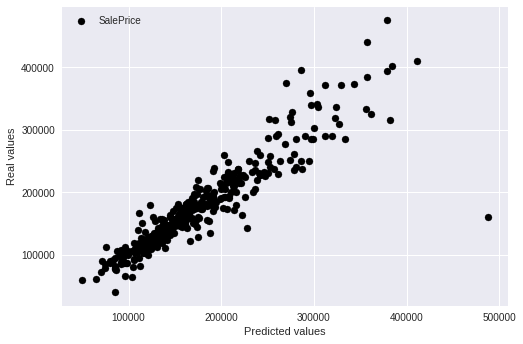

In [25]:
plt.scatter(ypred2, y_test2, c = "black")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.show()

###Step 7: Create predictions for submission

In [26]:
submission = tpot.predict(test[vlist])
sub2 = np.exp(submission)


submission2 = pd.DataFrame({
        "Id": test["Id"],
        "SalePrice": sub2
    })

submission2.to_csv('submission.csv', header=True,index=False)
files.download('submission.csv')

In [35]:
# X_test = X_test[X_train.columns]
# tpot.export('tpot_SalePrice.py')
# %load 'tpot_SalePrice.py'
# print(tpot.fitted_pipeline_)